In [5]:
#!pip install duckdb ydata-profiling pycaret

In [24]:
#!pip install duckdb

In [6]:
%matplotlib inline

In [25]:
import pandas as pd
import duckdb 
import plotnine as p9
import numpy as np
import xgboost as xgb

from utils.preprocess import treat_dataset_pandas_init, build_preprocessing_pipeline,INIT_NUMERICAL_COLS, numerical_features
from utils.metrics import rmsle_metric
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import root_mean_squared_log_error
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from utils.categoricals import CategoricalToStringTransformer, CategoricalEncoder


In [26]:
train_data = pd.read_csv("playground-series-s4e12/train.csv")#.sample(frac=0.1)
test_data = pd.read_csv("playground-series-s4e12/test.csv")

treated_dataset = treat_dataset_pandas_init(train_data, process_as_category=True)

X_train = treated_dataset.drop(columns=["Premium Amount"])
y_train = treated_dataset["Premium Amount"]


In [27]:
train_data['Policy Start Date'] = pd.to_datetime(train_data['Policy Start Date'])
test_data['Policy Start Date'] = pd.to_datetime(test_data['Policy Start Date'])



In [28]:
# Separate numeric and categorical columns
numeric_cols = train_data.select_dtypes(include=['float', 'int','bool']).columns
categorical_cols = train_data.select_dtypes(include=['object']).columns

In [29]:
numeric_cols

Index(['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'Premium Amount'],
      dtype='object')

# Revision temporal

In [30]:
# De cara a una competencia Kaggle la primera pregunta es si realmente podre explotar la informacion temporal. Tengo que ver como se relaciona temporalmente test y train.

In [31]:
# Function to sort columns by numeric first, then string/object-like
numeric_cols = [col for col in train_data.columns if np.issubdtype(train_data[col].dtype, np.number)]
non_numeric_cols = [col for col in test_data.columns if not np.issubdtype(test_data[col].dtype, np.number)]
target_col = "Premium Amount"
sorted_columns = numeric_cols + non_numeric_cols

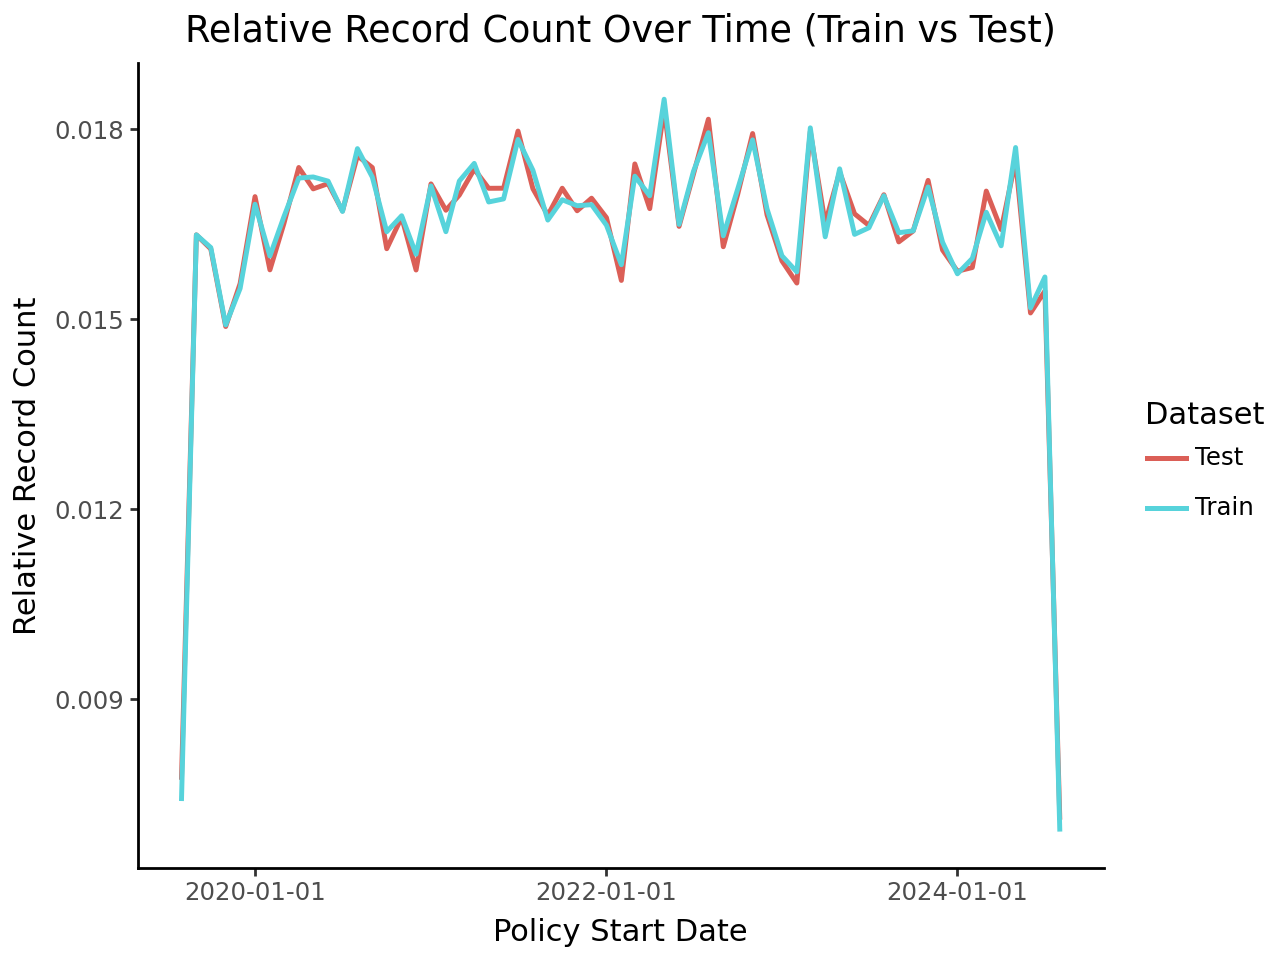

In [32]:
# Group by year-month and calculate the required metrics for train data
train_monthly_data = (
    train_data
    .groupby(train_data['Policy Start Date'].dt.to_period('M'))
    .agg(
        record_count=('Policy Start Date', 'size'),
        avg_premium=('Premium Amount', 'mean')
    )
    .reset_index()
)
train_monthly_data['Policy Start Date'] = train_monthly_data['Policy Start Date'].dt.to_timestamp()
train_monthly_data['Dataset'] = 'Train'

# Group by year-month and calculate the required metrics for test data
test_monthly_data = (
    test_data
    .groupby(test_data['Policy Start Date'].dt.to_period('M'))
    .agg(
        record_count=('Policy Start Date', 'size')
    )
    .reset_index()
)
test_monthly_data['Policy Start Date'] = test_monthly_data['Policy Start Date'].dt.to_timestamp()
test_monthly_data['Dataset'] = 'Test'

# Normalize the record_count for Train and Test data
train_monthly_data['relative_record_count'] = train_monthly_data['record_count'] / train_monthly_data['record_count'].sum()
test_monthly_data['relative_record_count'] = test_monthly_data['record_count'] / test_monthly_data['record_count'].sum()

# Combine the two dataframes
combined_data = pd.concat([
    train_monthly_data[['Policy Start Date', 'relative_record_count', 'Dataset']],
    test_monthly_data[['Policy Start Date', 'relative_record_count', 'Dataset']]
])

# Plot both datasets as relative measures
plot = (
    p9.ggplot(combined_data, p9.aes(x='Policy Start Date', y='relative_record_count', color='Dataset')) +
    p9.geom_line(size=1) +
    p9.labs(title='Relative Record Count Over Time (Train vs Test)',
            x='Policy Start Date',
            y='Relative Record Count') +
    p9.theme_classic()
)

plot

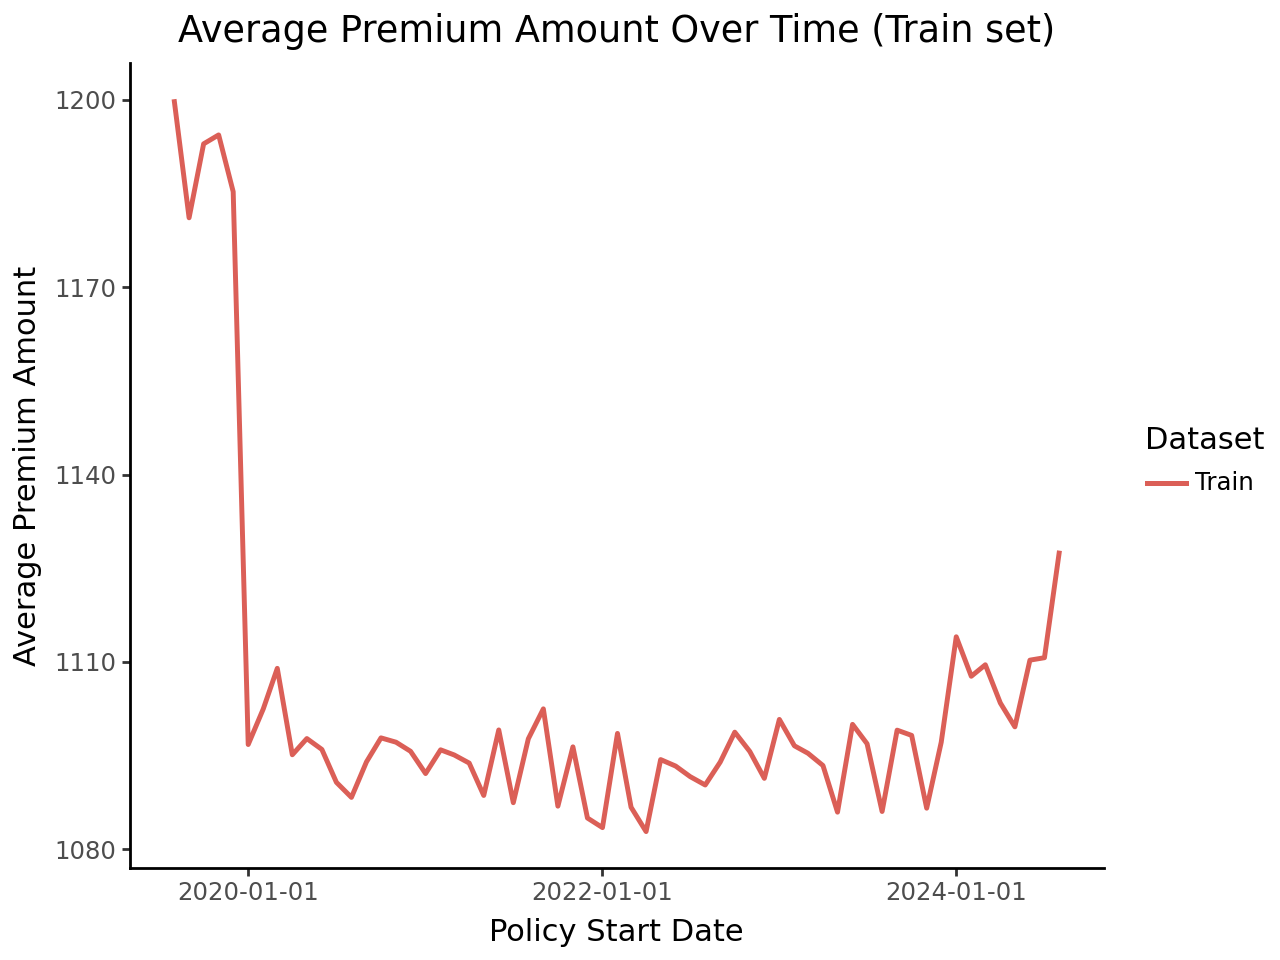

In [33]:
# Plot both datasets as relative measures
plot = (
    p9.ggplot(train_monthly_data, p9.aes(x='Policy Start Date', y='avg_premium', color='Dataset')) +
    p9.geom_line(size=1) +
    p9.labs(title='Average Premium Amount Over Time (Train set)',
            x='Policy Start Date',
            y='Average Premium Amount') +
    p9.theme_classic()
)

plot

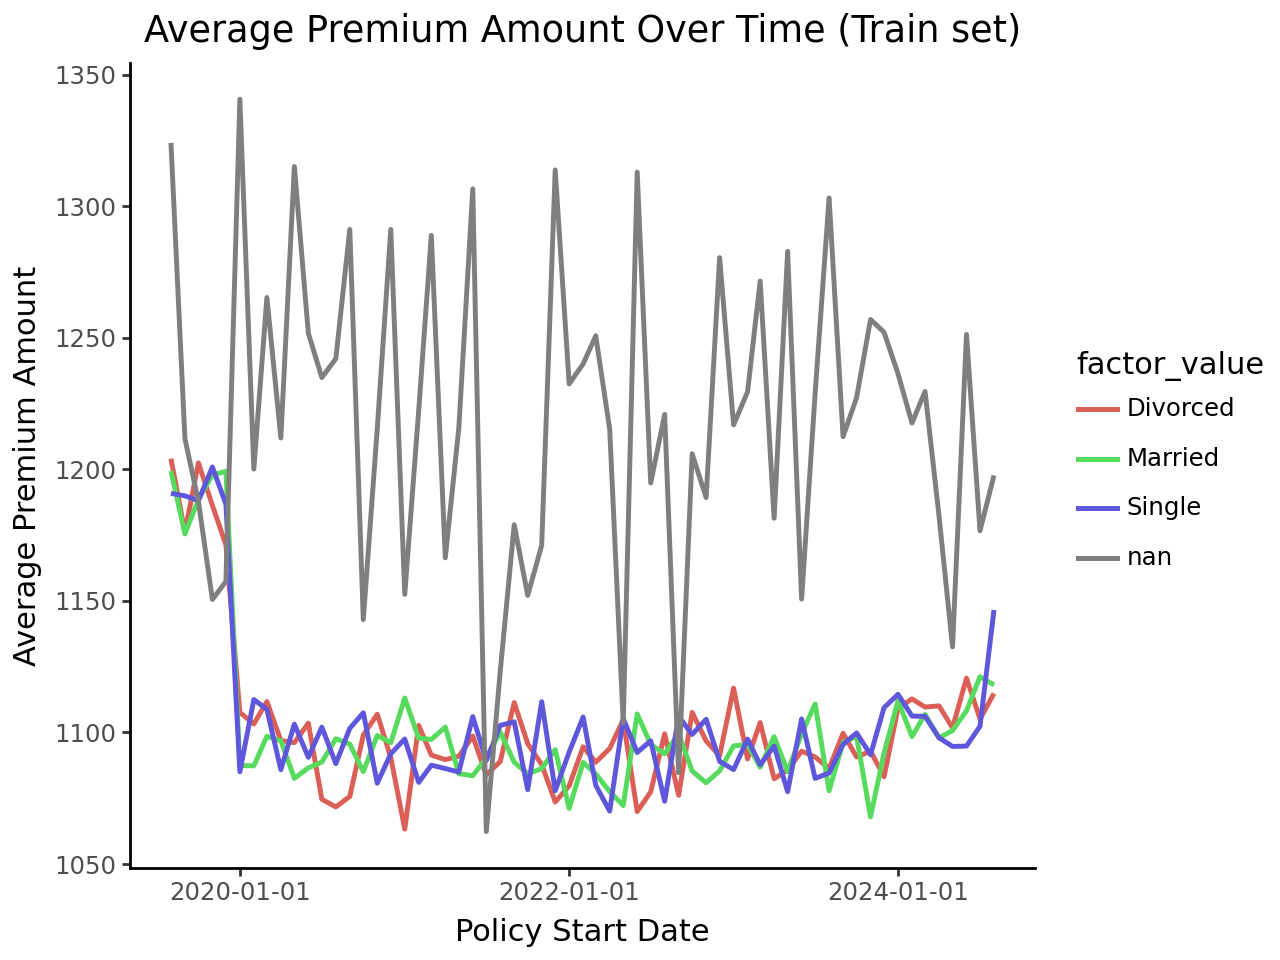

In [35]:
# Assuming `full_train_csv_data` is already loaded into DuckDB as a table, e.g., "full_train_csv_data"
factor = "Marital Status"

query = f"""
SELECT 
    DATE_TRUNC('month', "Policy Start Date") AS policy_start_month,
    "{factor}" AS factor_value,
    COUNT(*) AS record_count,
    AVG("Premium Amount") AS avg_premium
FROM train_data
GROUP BY 
    policy_start_month, 
    factor_value
ORDER BY 
    policy_start_month, 
    factor_value
"""

train_monthly_data_by_factor = duckdb.query(query).df()

# Plot both datasets as relative measures
plot = (
    p9.ggplot(train_monthly_data_by_factor, p9.aes(x='policy_start_month', y='avg_premium', color='factor_value')) +
    p9.geom_line(size=1) +
    p9.labs(title='Average Premium Amount Over Time (Train set)',
            x='Policy Start Date',
            y='Average Premium Amount') +
    p9.theme_classic()
)

plot

# NOTA: Preguntarse, porque es importante revisar la relacion entre test y train: tipos de CV.

# Target

In [36]:
%matplotlib inline

In [39]:
train_data["log_premium_amt"] = np.log1p(train_data["Premium Amount"])

In [40]:
import plotnine as p9


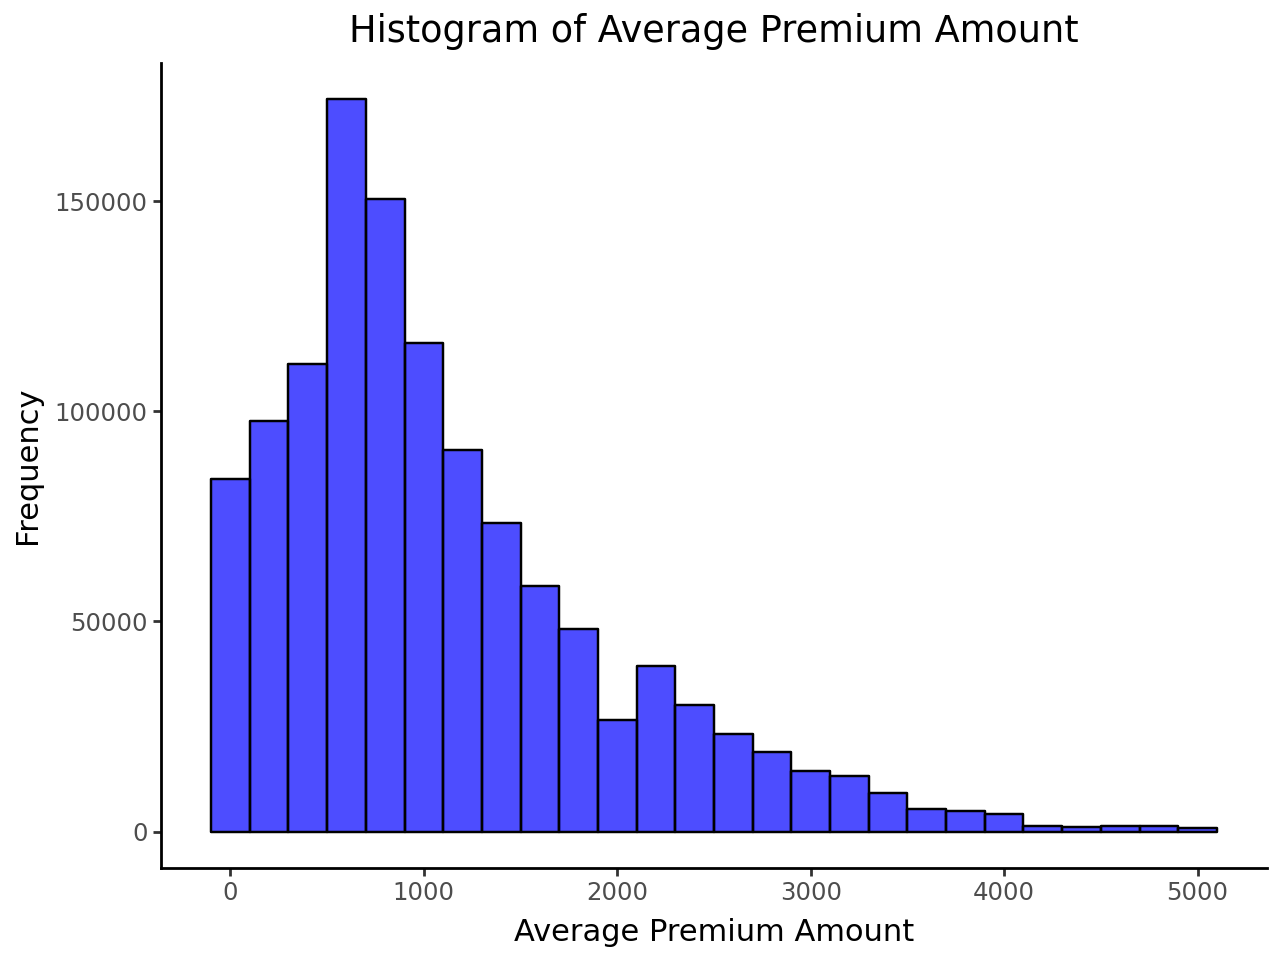

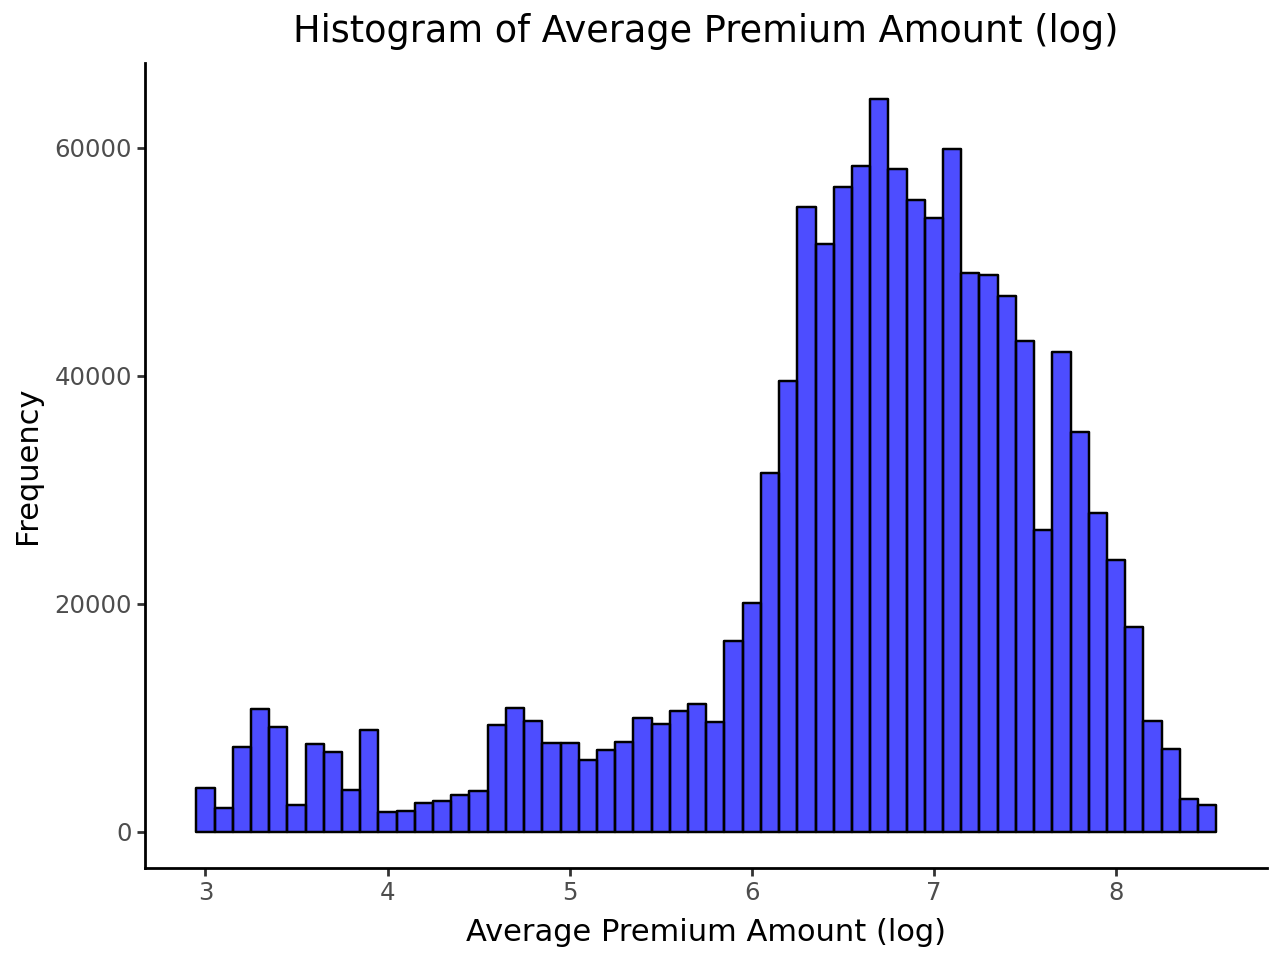

In [41]:
histogram_plot = (
    p9.ggplot(train_data, p9.aes(x='Premium Amount')) +
    p9.geom_histogram(binwidth=200, fill='blue', color='black', alpha=0.7) +
    p9.labs(title='Histogram of Average Premium Amount',
            x='Average Premium Amount',
            y='Frequency') +
    p9.theme_classic()
)

histogram_plot_log = (
    p9.ggplot(train_data, p9.aes(x='log_premium_amt')) +
    p9.geom_histogram(binwidth=0.1, fill='blue', color='black', alpha=0.7) +
    p9.labs(title='Histogram of Average Premium Amount (log)',
            x='Average Premium Amount (log)',
            y='Frequency') +
    p9.theme_classic()
)
display(histogram_plot, histogram_plot_log)

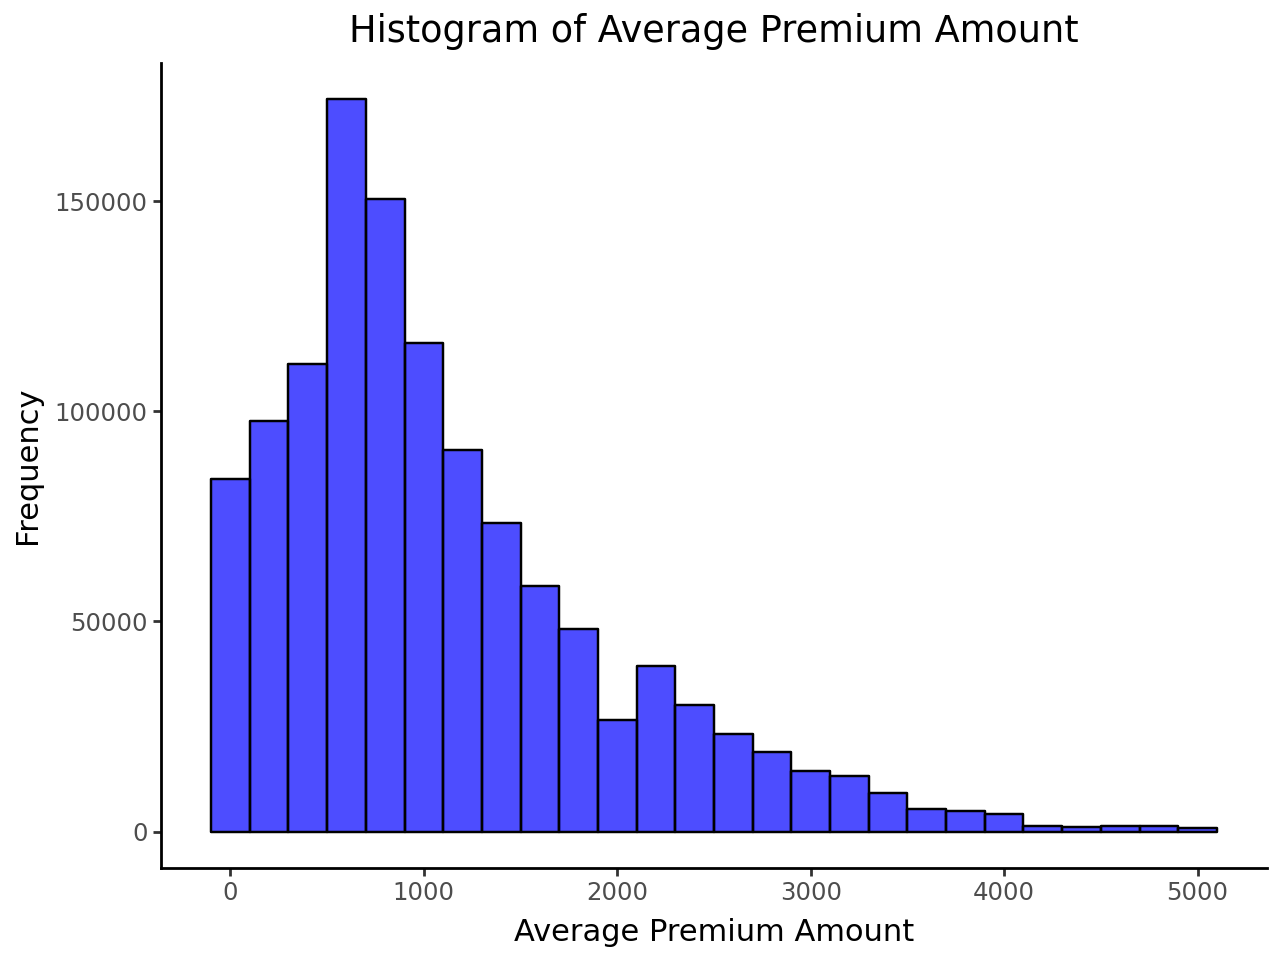

In [42]:


histogram_plot


# Check basico (en Sheets)

In [43]:
train_data[sorted_columns + ["Premium Amount"]].describe(include='all').to_clipboard()

In [23]:
train_data[sorted_columns].describe(include='all').to_clipboard()

In [44]:
train_results = {}
test_results = {}
for col in [col for col in non_numeric_cols if col != "Policy Start Date"]:
    train_results[col]= train_data[col].value_counts(normalize=True)
    test_results[col]= test_data[col].value_counts(normalize=True)

In [92]:
pd.DataFrame(train_results.values()).to_clipboard()

In [93]:
pd.DataFrame(test_results.values()).to_clipboard()

# Fast profile

In [11]:
train_data

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,...,NaN,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0
1199996,1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,...,NaN,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0
1199997,1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,...,0.0,19.0,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0
1199998,1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,...,1.0,7.0,407.0,4.0,2021-09-19 15:21:39.190215,Poor,No,Daily,Apartment,596.0


In [3]:
from ydata_profiling import ProfileReport

train_profile = ProfileReport(treated_dataset, title="Train")

In [3]:
#train_profile